# multiomics analysis - preprocessing

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity =1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/preprocessing/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

## Import data
Import sample metadata

In [4]:
data_dir = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/dual/'
meta = pd.read_csv(data_dir+'/meta.txt',index_col=0, sep='\t')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  14


In [5]:
meta

,donor,Library_ATAC,Library_RNA,iRods_path
sample,,,,
HD_F_GON9525419,Hrv15,HD_F_GON9525611,HD_F_GON9525419,/seq/illumina/cellranger-arc/cellranger-arc101...
HD_F_GON9525420,Hrv15,HD_F_GON9525612,HD_F_GON9525420,/seq/illumina/cellranger-arc/cellranger-arc101...
HD_F_GON9525421,Hrv39,HD_F_GON9525613,HD_F_GON9525421,/seq/illumina/cellranger-arc/cellranger-arc101...
HD_F_GON9525422,Hrv39,HD_F_GON9525614,HD_F_GON9525422,/seq/illumina/cellranger-arc/cellranger-arc101...
FCA_GND10287600,Hrv58,FCA_GND10288176,FCA_GND10287600,/seq/illumina/cellranger-arc/cellranger-arc101...
FCA_GND10287601,Hrv58,FCA_GND10288177,FCA_GND10287601,/seq/illumina/cellranger-arc/cellranger-arc101...
FCA_GND10287602,Hrv39,FCA_GND10288178,FCA_GND10287602,/seq/illumina/cellranger-arc/cellranger-arc101...
FCA_GND10287603,Hrv65,FCA_GND10288179,FCA_GND10287603,/seq/illumina/cellranger-arc/cellranger-arc101...
FCA_GND10287604,Hrv65,FCA_GND10288180,FCA_GND10287604,/seq/illumina/cellranger-arc/cellranger-arc101...


## Preprocessing
### Load 10x 

Filter: 1) cells (< 10 genes); 2) genes (< 3 cells) 

Quantify: 1) % mitochondrial genes; 2) total counts


In [6]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(data_dir+'/'+sample+'/filtered_feature_bc_matrix/',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

HD_F_GON9525419
Total number of cells: 1412
Total number of genes: 25563
HD_F_GON9525420
Total number of cells: 1455
Total number of genes: 25699
HD_F_GON9525421
Total number of cells: 2036
Total number of genes: 25874
HD_F_GON9525422
Total number of cells: 3556
Total number of genes: 28076
FCA_GND10287600
Total number of cells: 3164
Total number of genes: 30620
FCA_GND10287601
Total number of cells: 3136
Total number of genes: 31179
FCA_GND10287602
Total number of cells: 1642
Total number of genes: 28667
FCA_GND10287603
Total number of cells: 2472
Total number of genes: 31859
FCA_GND10287604
Total number of cells: 5095
Total number of genes: 29991
HCA_F_GON10713284
Total number of cells: 4882
Total number of genes: 31081
HCA_F_GON10713285
Total number of cells: 6353
Total number of genes: 31237
HCA_F_GON10713286
Total number of cells: 6877
Total number of genes: 31284
HCA_F_GON10535495
Total number of cells: 12650
Total number of genes: 31241
HCA_F_GON10535496
Total number of cells: 2

In [7]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

14


AnnData object with n_obs × n_vars = 74730 × 33998
    obs: 'n_genes', 'sample', 'donor', 'Library_ATAC', 'Library_RNA', 'iRods_path', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9'

### QC pplots

Plot distributions of the values n_genes, n_counts and percent_mito

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'Library_ATAC' as categorical
... storing 'Library_RNA' as categorical
... storing 'iRods_path' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'gene_ids-12' as categorical
... storing 'feature_types-12' as categorical
... storing 'gene_ids-13' as categorical
... storing 'feature_types-13' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
... storing 'gene_ids-4' as categorical
... storing 'feature_types-4' as categorical
... storing 'gene_ids-5' as categ

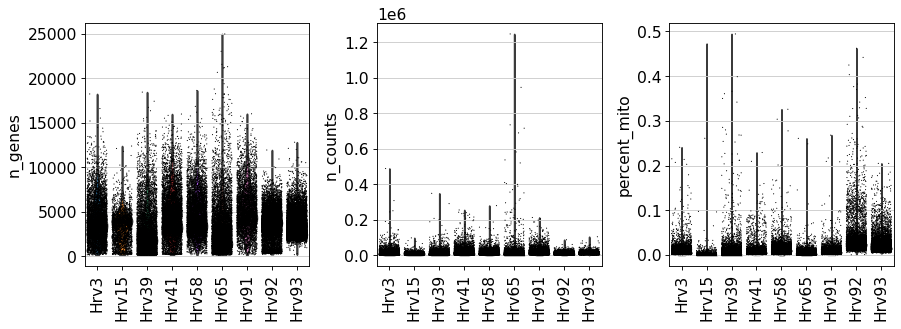

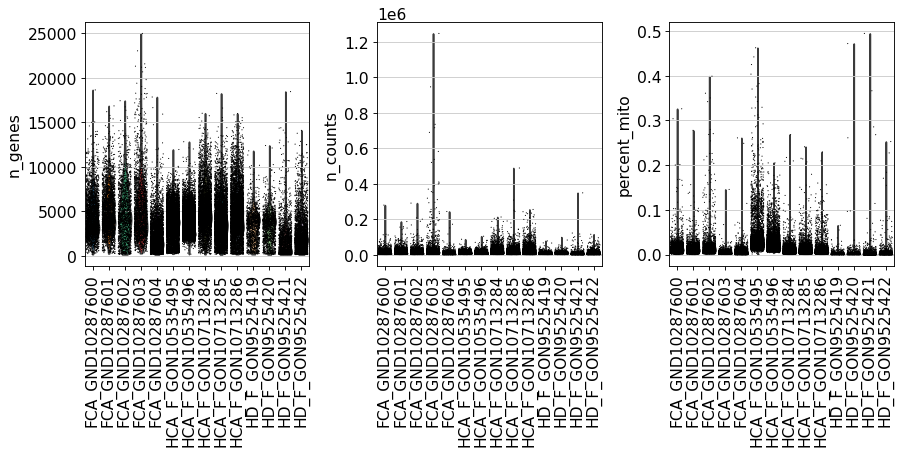

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='donor', rotation = 90, jitter=0.4, save='_perindividual.pdf', show=True)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='sample', rotation = 90, jitter=0.4, save='_persample.pdf', show=True)

In [10]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_prefilters.csv')

Total number of cells: 74730
Total number of genes: 33998


### Sex specific genes

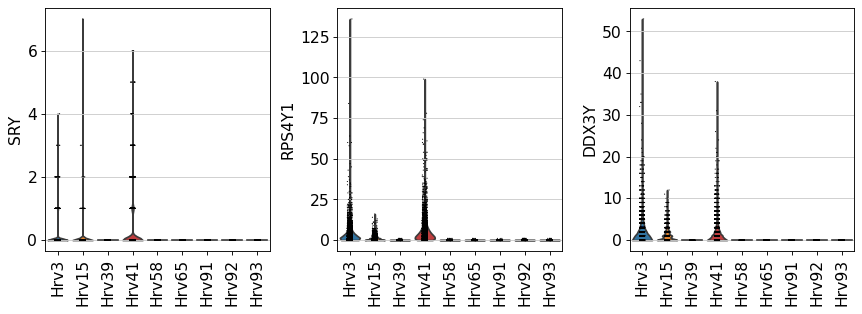

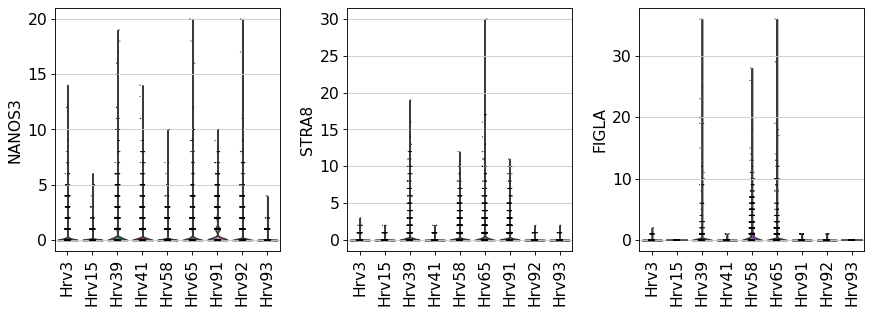

In [25]:
sc.pl.violin(adata, ['SRY', 'RPS4Y1','DDX3Y'], groupby='donor', rotation = 90) # MALE?
sc.pl.violin(adata, ['NANOS3', 'STRA8', 'FIGLA'], groupby='donor', rotation = 90)# OOCYTES?

### Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

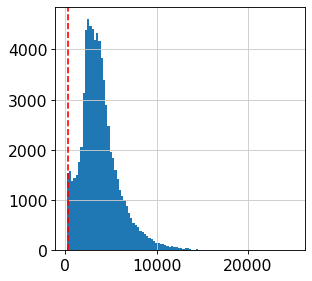

In [12]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(300, linestyle = '--', color = 'red')

In [13]:
sc.pp.filter_cells(adata, min_genes=300)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 73871
Total number of genes: 33998


,counts,freqs
categories,,
Hrv3,6317,0.085514
Hrv15,2822,0.038202
Hrv39,6719,0.090956
Hrv41,6786,0.091863
Hrv58,6294,0.085203
Hrv65,7427,0.100540
Hrv91,4869,0.065912
Hrv92,12638,0.171082
Hrv93,19999,0.270729


### Filter genes expressed in less than 3 cells

In [15]:
sc.pp.filter_genes(adata, min_cells=3)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 73871
Total number of genes: 33997


,counts,freqs
categories,,
Hrv3,6317,0.085514
Hrv15,2822,0.038202
Hrv39,6719,0.090956
Hrv41,6786,0.091863
Hrv58,6294,0.085203
Hrv65,7427,0.100540
Hrv91,4869,0.065912
Hrv92,12638,0.171082
Hrv93,19999,0.270729



### Filter cells with large % mitochondrial genes

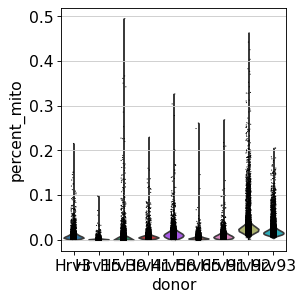

In [17]:
sc.pl.violin(adata, ['percent_mito'], groupby='donor') #hPGCs

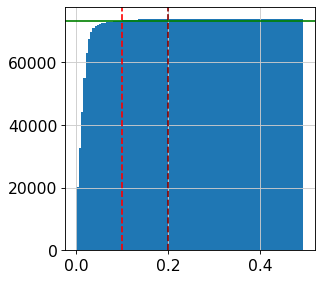

In [18]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [19]:
# >10%
adata = adata[adata.obs['percent_mito'] < 0.1, :]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 73218
Total number of genes: 33997


## Save raw counts

In [21]:
adata.raw = adata.copy()

## Load scrublet

In [22]:
data_dir = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/dual/'
meta = pd.read_csv(data_dir+'/meta.txt',index_col=0, sep='\t')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  14


In [23]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]

# Save

In [26]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata.write(path_to_gonads+'multiomics_rna_counts.h5ad')